In [1]:
import pandas as pd, numpy as np, mglearn, numpy.linalg as nl, inspect, seaborn as sns, plotly, plotly.express as px,umap, pickle, plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tqdm import tqdm
from matplotlib.pyplot import *
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
pd.options.display.float_format = '{:,.4f}'.format

/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-25 10:23:43.812112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 10:23:44.376938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tylman/anaconda3/envs/ketsu/lib/:/home/tylman/anaconda3/envs/ketsu/lib/
2023-02-25 10:23:44.377049: W tensorflow/compiler/xla/s

In [2]:

#To save time due to the contraints of the exam schedule, I am only going to apply one form of normalization that I have 
#found good luck with in the past, instead of attempting to employ multiple and suss out the best of them as we normally would.
def ty_normalize(train_df,test_df):
    train, test = train_df.copy(), test_df.copy()
    scaler = StandardScaler()
    scaler.fit(train)
    train = normalize(scaler.transform(train))
    test = normalize(scaler.transform(test))
    return train, test

In [19]:
from sklearn.datasets import fetch_california_housing
cal_housing = fetch_california_housing()
x, y = cal_housing['data'], cal_housing['target']

#Ensure end-to-end success after changing to dataframes!!

x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=.2,random_state=38)


x_train, x_test = ty_normalize(x_train,x_test)

x_train, x_test = pd.DataFrame(data=x_train,columns=cal_housing['feature_names']), pd.DataFrame(data=x_test, columns=cal_housing['feature_names'])
y_train, y_test = pd.DataFrame(data=y_train,columns=cal_housing['target_names']), pd.DataFrame(data=y_test, columns=cal_housing['target_names'])


# train_combo = (x_train,y_train)
# test_combo = (x_test, y_test)

In [44]:
print(cal_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [5]:
#out_dir is for things which are ugly and we won't put in the final pdf
out_dir = Path('output')
out_dir.mkdir(exist_ok=True)
#Res_dir is for things which are meant for final analysis. (In my system, out_dir is excluded via .gitignore, and res_dir is not)
res_dir = Path('results')
res_dir.mkdir(exist_ok=True)
save = True
train_model_q4 = False
train_model_q5 = True




In [6]:
def make_ridge(alpha):
    return Ridge(alpha=alpha)
def basic_analyze(make_func,attr_list, train_data, test_data,attr_name= 'attribute' ,save = False, out_dir = ''):
    result = []
    for attr in tqdm(attr_list):
        model = make_func(attr)
        model.fit(train_data[0],train_data[1])
        result.append([attr,model.score(train_data[0],train_data[1]), model.score(test_data[0],test_data[1])])
        del(model)
    df = pd.DataFrame(columns = [attr_name,'train_score','test_score'],data=result)
    if save:
        df.to_csv(Path(out_dir,'Performance.csv'),index=False)
        if df.shape[0] >10:
            df.iloc[:10].to_latex(Path(out_dir,'Performance.tex'),index=False)
        else:
            df.to_latex(Path(out_dir,'Performance.tex'),index=False)
    return df

def plot_result(item, x_name, title, save = False, out_dir = ''):
    if type(item) == type(Path('.')):
        df = pd.read_csv(item)
    else:
        df = item
    plt = df.plot(x=x_name, ylabel='R^2 Score',title=title)
    if save:
        plt.get_figure().savefig(Path(out_dir,'plot.png'))

In [7]:
# ridge_attr = np.linspace(0,10,1001)
# ridge_out_dir = Path(out_dir,'ridge')
# if not ridge_out_dir.is_dir():
#     ridge_out_dir.mkdir()
# ridge_res = basic_analyze(make_ridge, ridge_attr, train_combo, test_combo, attr_name='Alpha', save=True, out_dir=ridge_out_dir)
# plot_result(ridge_res, 'Alpha', 'Ridge Performance', save=save, out_dir = ridge_out_dir)

In [8]:
# #Display the best Alpha for the ridge Regression Model
# ridge_res.iloc[ridge_res['test_score'].argmax()]

In [9]:
def load_model(model,loc=out_dir):
    filname = list(Path(loc).rglob('*'+model+'*'))
    if len(filname) == 0:
        raise ValueError("Can't find the file!")
    if len(filname) >1:
        raise ValueError("Located too many items matching that search. Please try again. We found: {}".format(filname))
    filname = filname[0]
    with open(filname,'rb') as fil:
        temp = pickle.load(fil)
    return temp

def seaborn_friendly(res):
    res['mean_score'] = res[['mean_train_score','mean_test_score']].values.tolist()
    res['type'] = [['train','test']]*res.shape[0]
    res['std_score'] = res[['std_train_score','std_test_score']].values.tolist()
    res = res.explode(['mean_score','type','std_score'],ignore_index=True)
    return res

def plot_cv_param_res(res,xs, param, save=False, out_dir = '.',key='model', y='mean_score'):
    test = seaborn_friendly(res)
    if isinstance(xs,str):
        xs = [xs] 
    for x in xs:
        ax = sns.lineplot(x=x, y=y,hue=param,style='type',data=test)
        ax.set(title="{} {} by {}".format(key.upper(),y,param))
        if save:
            ax.get_figure().savefig(Path(out_dir,f"{param}_{y}_{x}.png"))
        show()

In [10]:
def analyze(key, x, test_x, test_y, save=False, out_dir='.', loc=out_dir):
    model_res = load_model(key,loc=loc)
    df =  pd.DataFrame.from_dict(model_res.cv_results_)
    if 'knn' in key:
        #Bootlegged solution to an annoying naming problem
        df.loc[~df['param_weights'].isin(['uniform','distance']),'param_weights'] = 'rbf'
    if 'rf' in key:
        #Switch out the value with no limit of depth to be in line with the others, but slightly separated to notice it better.
        mask = df['param_max_depth'].isna()
        df.loc[mask,'param_max_depth'] = df.loc[~mask, 'param_max_depth'].max()+2*df.loc[~mask, 'param_max_depth'].diff().max()
    ys = df.filter(regex='param').columns
    model_res_dir = Path(out_dir,key)
    if save:
        model_res_dir.mkdir(exist_ok=True)
    if isinstance(x,str):
        droppables = [x,'params']
    else:
        droppables = x + ['params']
        contour_continuous(df,x[0],x[1],'{} Continuous Test Accuracy'.format(key.upper()), save=save, out_dir=model_res_dir)
    ys = ys.drop(droppables)
    if ys.shape[0] == 0 :
        ys = ['bootleg_solution_im_sorry']
    for param in ys:
        if param == 'bootleg_solution_im_sorry':
            param = None
        plot_cv_param_res(df, x, param, save=save, out_dir=model_res_dir, key = key)
        plot_cv_param_res(df, x, param, save=save, out_dir=model_res_dir, key = key,y='mean_fit_time')
    best_res = handle_best(key, test_x, test_y, save=save, out_dir=model_res_dir)
    return df, best_res
    
def contour_continuous(df, x, y, title='placeholder',save = False, out_dir='.'):
    fig = go.Figure(data= go.Contour(z=df['mean_test_score'],x=df[x],y = df[y]))
    fig.update_layout(title=title, xaxis_title=x, yaxis_title=y)
    if save:
        plotly.offline.plot(fig, filename=str(Path(out_dir,'contour.html')),auto_open=False)
    fig.show()

def handle_best(key, test_x, test_y, save=False, out_dir = out_dir):
    res = load_model(key)
    best_model = res.best_estimator_    
    df =  pd.DataFrame.from_dict(res.cv_results_)
    best_res = df.iloc[res.best_index_]
    best_res['best_final_test'] = best_model.score(test_x,test_y)
    best_res['best_cv_test'] = res.cv_results_['mean_test_score'][res.best_index_]
    best_res['best_cv_train'] = res.cv_results_['mean_train_score'][res.best_index_]
    if save:
        print(out_dir)
        best_res.to_csv(Path(out_dir,'{}_best_results.csv'.format(key)))
        best_res.to_latex(Path(out_dir,'{}_best_results.tex'.format(key)))
    return best_res

def wrap_up(res_dir):
    df = pd.concat([pd.read_csv(i,index_col=0,names=[i.name.split('_')[0]],header=None) for i in res_dir.rglob("*best_results.csv")],axis=1).dropna()
    df.rename(index={df.index[0]:'Index'},inplace=True)
    df.to_csv(Path(res_dir,'all_best.csv'),float_format='%.4f')
    df.to_latex(Path(res_dir,'all_best.tex'),float_format='%.4f')

In [11]:
#Allows End-To-End repeating of data generation by loading pre-existing trained models
if train_model_q4:
    ridge_grid = {'alpha':np.linspace(0,10,1001)}
    ridge = Ridge()
    ridge_cv = GridSearchCV(ridge,ridge_grid, n_jobs=-1, verbose=10, cv=4, return_train_score=True)
    ridge_cv.fit(x_train, y_train.values.flatten())
    if save:
        with open(Path(out_dir,'Ridge_cv.pkl'),'wb') as fil:
            pickle.dump(ridge_cv, fil)
    del(ridge_cv)

    #Originally was goint to do multiple forms of pruning, but seeing that you requested the Pruning parameter (not plural)
    #And there is no one pruning parameter, I figured you meant to just vary one of the options for pruning. I chose max_depth
    #Since that's what you asked for on the next problem.
    DT_grid = {'max_depth':np.arange(0,99)+1}#, 'min_samples_leaf':np.arange(0,9)+1}
    dt = DecisionTreeRegressor()
    DT_cv = GridSearchCV(dt,DT_grid, n_jobs=-1, verbose=10, cv=4, return_train_score=True)
    DT_cv.fit(x_train,y_train.values.flatten())
    if save:
        with open(Path(out_dir,'DT_cv.pkl'),'wb') as fil:
            pickle.dump(DT_cv, fil)
    del(DT_cv)


    rf = RandomForestRegressor()
    estimators = np.arange(0, 20) + 1
    max_depth = np.arange(0,30) + 1
    #max_depth.append(None)
    max_features = ['sqrt','log2']
    rf_grid = {'n_estimators':estimators, 'max_depth':max_depth, 'max_features':max_features}
    rf_cv = GridSearchCV(rf, rf_grid, n_jobs=-1,verbose=10, cv=4,return_train_score=True)
    rf_cv.fit(x_train,y_train.values.flatten())
    if save:
        with open(Path(out_dir,'rf_cv.pkl'),'wb') as fil:
            pickle.dump(rf_cv, fil)
    del(rf_cv)


    


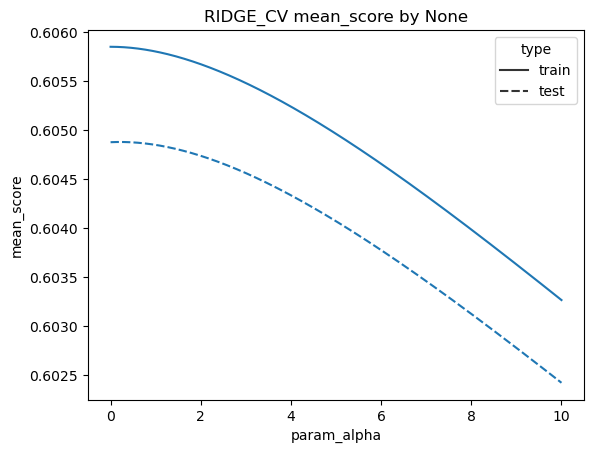

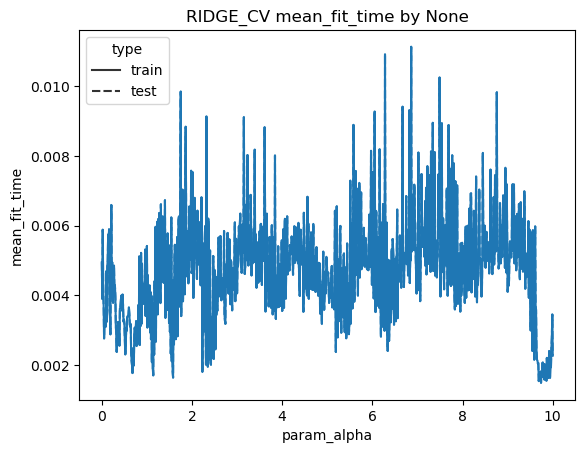

/tmp/ipykernel_601/3575795740.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_res['best_final_test'] = best_model.score(test_x,test_y)
/tmp/ipykernel_601/3575795740.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_res['best_final_test'] = best_model.score(test_x,test_y)
/tmp/ipykernel_601/3575795740.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_res['best_cv_test'] = res.cv_results_['mean_test_score'][res.

results/Ridge_cv


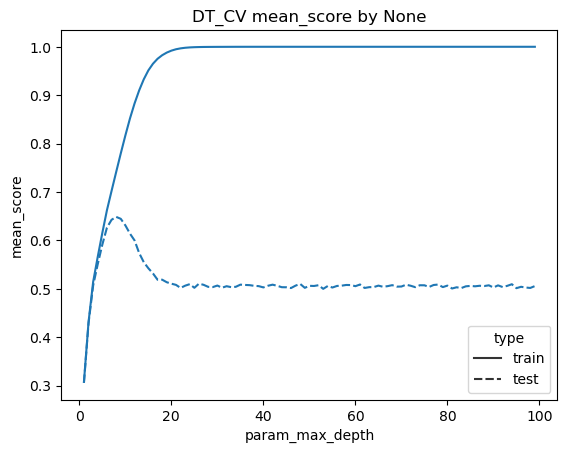

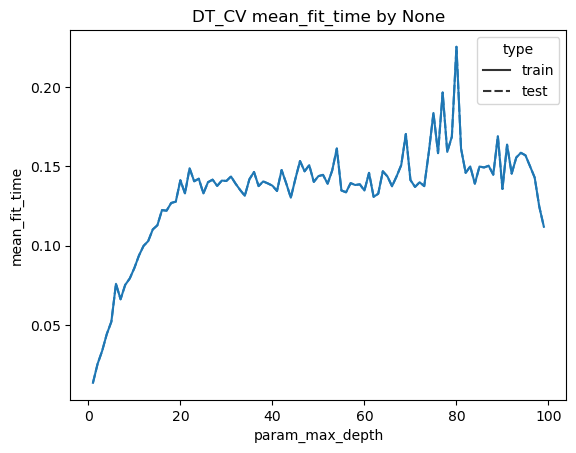

/tmp/ipykernel_601/3575795740.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_res['best_final_test'] = best_model.score(test_x,test_y)
/tmp/ipykernel_601/3575795740.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_res['best_final_test'] = best_model.score(test_x,test_y)
/tmp/ipykernel_601/3575795740.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_res['best_cv_test'] = res.cv_results_['mean_test_score'][res.

results/DT_cv


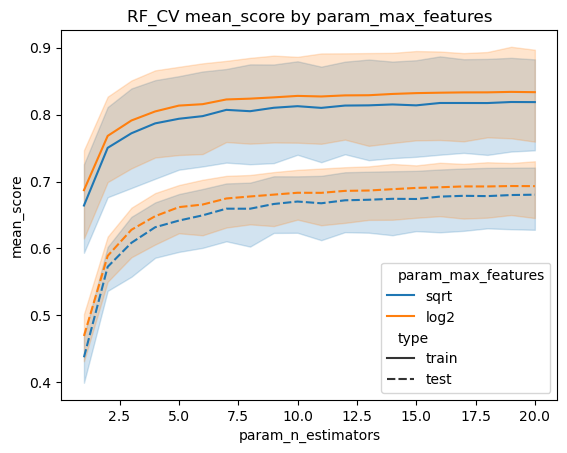

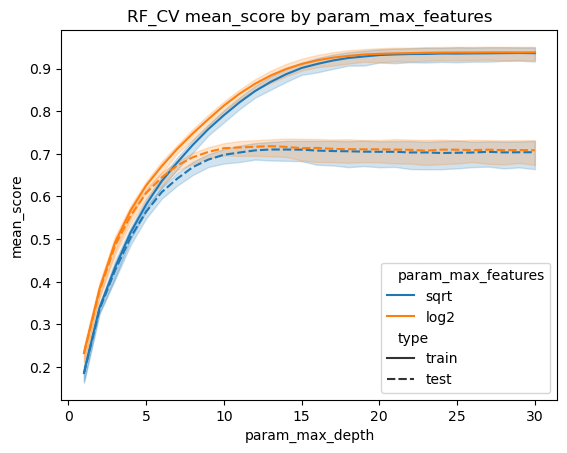

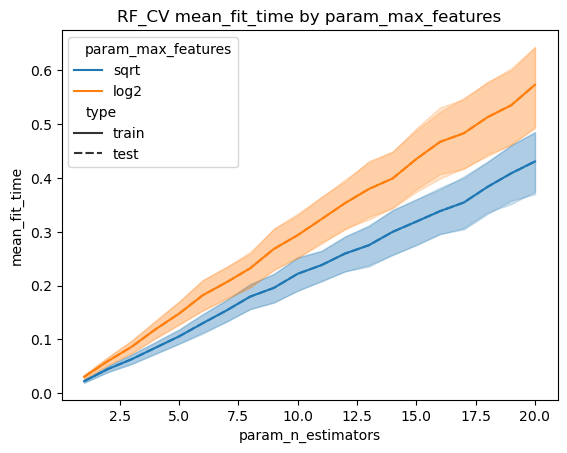

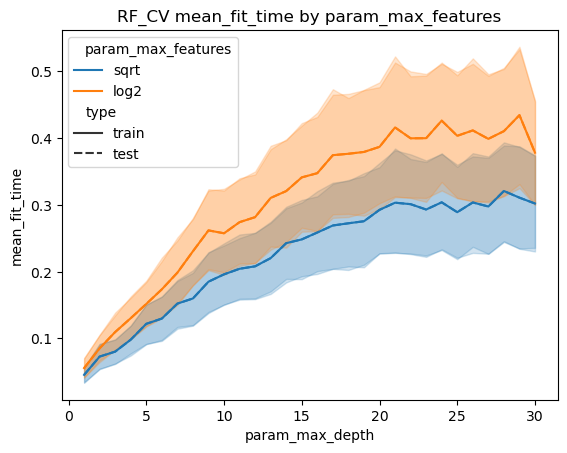

results/rf_cv


/tmp/ipykernel_601/3575795740.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_601/3575795740.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_601/3575795740.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_601/3575795740.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [12]:
keys = ['Ridge_cv','DT_cv','rf_cv']
xs = ['param_alpha','param_max_depth',['param_n_estimators','param_max_depth']]
df_dict = {}
#NOTE: This assumes that you have the existing .pkl files to load the models.
for key, x in zip(keys,xs):
    temp = analyze(key,x, x_test, y_test, save=save, out_dir=res_dir)
    if key not in df_dict.keys():
        df_dict[key] = temp
#This is to combine the resulting best data into one table for everything
if save:
    wrap_up(res_dir)

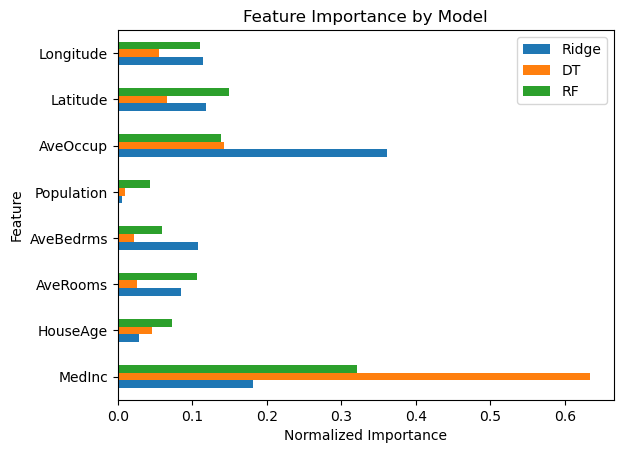

In [42]:
best_ridge = load_model('Ridge').best_estimator_
best_dt = load_model('DT').best_estimator_
best_rf = load_model('rf').best_estimator_
feature_importance = pd.DataFrame(columns=x_train.columns,data =[np.abs(best_ridge.coef_), best_dt.feature_importances_, best_rf.feature_importances_],index=['Ridge','DT','RF'])
feature_importance = feature_importance.div(feature_importance.sum(axis=1),axis=0)
ax = feature_importance.T.plot.barh(title="Feature Importance by Model",xlabel="Normalized Importance",ylabel="Feature")
if save:
    ax.get_figure().savefig(Path(res_dir,'Features.png'),bbox_inches='tight')

In [34]:
feature_importance

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  2.1662    0.3379    1.0167     1.2890      0.0629    4.3208    1.4198   
1  0.6340    0.0466    0.0252     0.0219      0.0093    0.1424    0.0655   
2  0.3212    0.0722    0.1070     0.0594      0.0429    0.1386    0.1489   

   Longitude  
0     1.3657  
1     0.0551  
2     0.1099

In [ ]:
#### MARK THE END OF PROBLEM 4 AND THE BEGINNING OF PROBLEM 5

In [56]:
from sklearn.datasets import load_digits
digits = load_digits()

In [93]:
x, y = digits.data, digits.target

x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=.2,random_state=0)

# x_train, x_test = pd.DataFrame(data=x_train,columns=digits['feature_names']), pd.DataFrame(data=x_test, columns=digits['feature_names'])
# y_train, y_test = pd.DataFrame(data=y_train,columns=digits['target_names']), pd.DataFrame(data=y_test, columns=digits['target_names'])

#x_train, x_test = ty_normalize(x_train,x_test)

In [58]:
#I wanted to separate the results of 4 and 5, which this allows me to do.
res_dir5 = Path('results5')
res_dir5.mkdir(exist_ok=True)

In [ ]:
if train_model_q5:
    gb = GradientBoostingClassifier()
    #losses = ['log_loss','exponential']
    learning_rates = np.linspace(.01, 2, 20)
    n_estimators = np.arange(0, 20) + 1
    max_depth = [3,4,5] #Keeping this low to save time, and allow for nice grouping graphs
    gb_grid = {'learning_rate' : learning_rates, "n_estimators":n_estimators, "max_depth":max_depth}#,'loss':losses}
    gb_cv = GridSearchCV(gb, gb_grid,n_jobs=-1,verbose=10, cv=4,return_train_score=True)
    gb_cv.fit(x_train,y_train)
    if save:
        with open(Path(out_dir,'gb_cv.pkl'),'wb') as fil:
            pickle.dump(gb_cv, fil)
    del(gb_cv)


Fitting 4 folds for each of 1200 candidates, totalling 4800 fits
[CV 1/4; 1/1200] START learning_rate=0.01, max_depth=3, n_estimators=1..........
[CV 3/4; 1/1200] START learning_rate=0.01, max_depth=3, n_estimators=1..........
[CV 1/4; 2/1200] START learning_rate=0.01, max_depth=3, n_estimators=2..........
[CV 4/4; 1/1200] START learning_rate=0.01, max_depth=3, n_estimators=1..........
[CV 2/4; 2/1200] START learning_rate=0.01, max_depth=3, n_estimators=2..........
[CV 4/4; 2/1200] START learning_rate=0.01, max_depth=3, n_estimators=2..........
[CV 2/4; 1/1200] START learning_rate=0.01, max_depth=3, n_estimators=1..........
[CV 1/4; 3/1200] START learning_rate=0.01, max_depth=3, n_estimators=3..........
[CV 2/4; 3/1200] START learning_rate=0.01, max_depth=3, n_estimators=3..........
[CV 1/4; 4/1200] START learning_rate=0.01, max_depth=3, n_estimators=4..........
[CV 4/4; 3/1200] START learning_rate=0.01, max_depth=3, n_estimators=3..........
[CV 3/4; 2/1200] START learning_rate=0.01, m

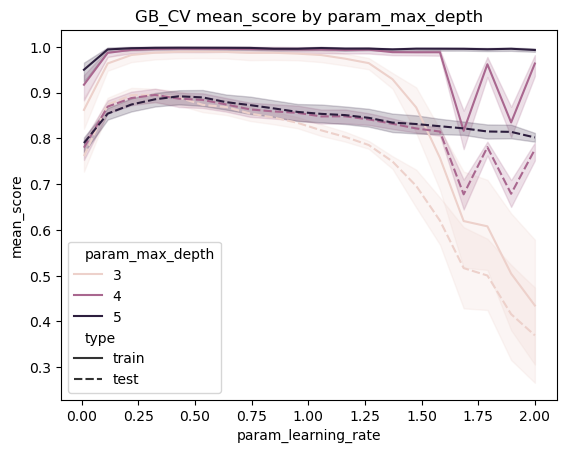

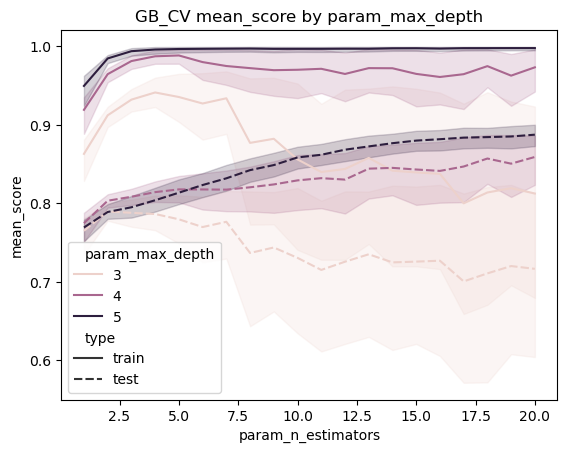

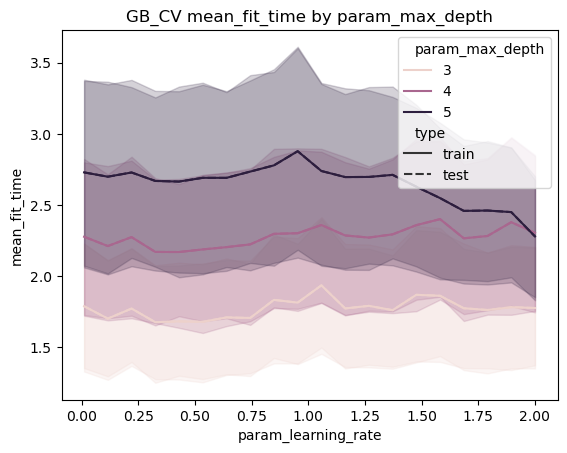

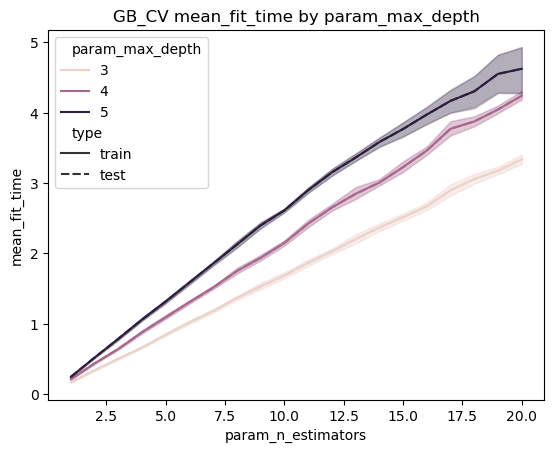

results5/gb_cv


/tmp/ipykernel_7220/3575795740.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_7220/3575795740.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_7220/3575795740.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_7220/3575795740.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

In [ ]:
keys = ['gb_cv']
xs = [['param_learning_rate','param_n_estimators']]
df_dict = {}
for key, x in zip(keys,xs):
    temp = analyze(key,x, x_test, y_test, save=save, out_dir=res_dir5)
    if key not in df_dict.keys():
        df_dict[key] = temp
#This is to combine the resulting best data into one table for everything
if save:
    wrap_up(res_dir5)

In [49]:
best_gb = load_model('gb').best_estimator_
image_data = best_gb.feature_importances_
image_data = ((1 - image_data / image_data.max())*255).reshape(8,8)

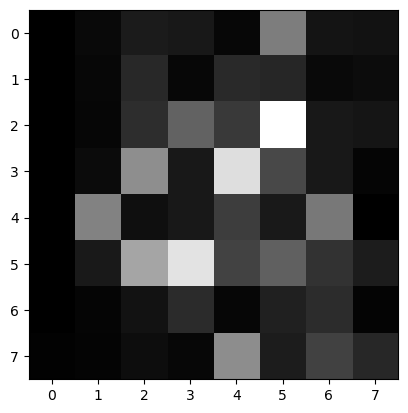

In [53]:
ax = imshow(image_data,cmap=cm.gray_r,interpolation='nearest')
if save:
    ax.get_figure().savefig(Path(res_dir5,'Features_Digits.png'),bbox_inches='tight')

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

In [73]:
predicted = best_gb.predict(x_test)


Confusion matrix:
[[26  0  0  0  0  1  0  0  0  0]
 [ 0 33  0  0  1  0  0  0  0  1]
 [ 1  1 31  1  0  0  0  1  1  0]
 [ 0  0  2 26  0  0  0  0  1  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 38  0  0  0  2]
 [ 0  1  0  0  0  0 42  0  1  0]
 [ 0  0  0  0  2  0  0 35  0  2]
 [ 0  1  0  2  0  0  1  0 35  0]
 [ 0  0  0  2  0  2  0  2  0 35]]


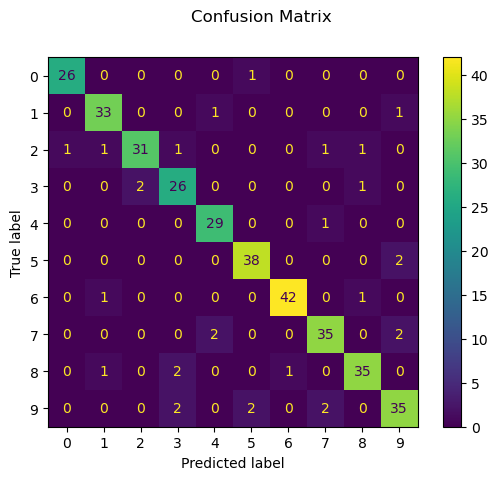

In [75]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
if save:
    disp.figure_.savefig(Path(res_dir5,'Digits_Confusion'),bbox_inches='tight')
print(f"Confusion matrix:\n{disp.confusion_matrix}")

In [84]:
res = pd.DataFrame()
res['truth'] = y_test
res['pred'] = predicted
res['idx'] = res.index

In [89]:
plottable = res.loc[res['truth'] != res['pred']].groupby('truth').first().reset_index()

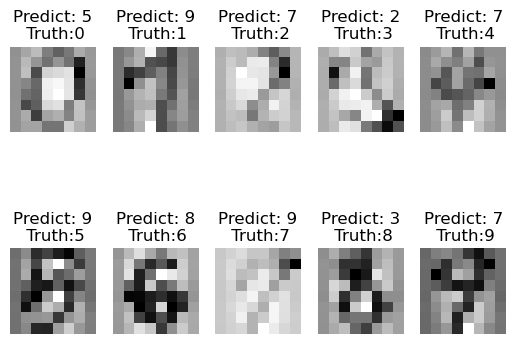

In [92]:
fig, axes = subplots(nrows=2,ncols=5)
for _,row in plottable.iterrows():
    truth = row['truth']
    ax = axes[truth // 5, truth % 5]
    ax.set_axis_off()
    image = x_test[row['idx']].reshape(8,8)
    ax.imshow(image, cmap=cm.gray_r,interpolation="nearest")
    ax.set_title(f"Predict: {row['pred']}\n Truth:{truth}")
